<a href="https://colab.research.google.com/github/marcinwolter/AI_Lublin_2023/blob/main/TransferLearningExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='green'>Transfer learning</font>**



<img src = 'https://editor.analyticsvidhya.com/uploads/444861_2vse-G3FKMT2D59NFWduMA.jpg' width=450px>

With transfer learning, we basically try to use what we’ve learned in one task to better understand the concepts in another. Weights are being automatically being shifted to a network performing “task A” from a network that performed new “task B.”


# <font color='green'>**An example – pattern recognition**
# <font color='green'>**on CIFAR10 photos dataset**

**CIFAR10** small image classification. <br>Dataset of 50\,000 32x32 color training images\, labeled over 10 categories\, and 10\,000 test images\.</span>

<img src='https://raw.githubusercontent.com/marcinwolter/Machine-learning-KISD-2022/main/images/lecture7/MachineLearning2020_733.png' width=450px>






**This program uses a subsample of CIFAR10 dataset: only three first classes (airplane, automobil, bird) and only 10 000 events for training.**
Without transfer learning a regular convolutional neural network (commented out in the code) is unable to make a decent classification. With transfer learning the accuracy of about 86% is achieved.

In [77]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

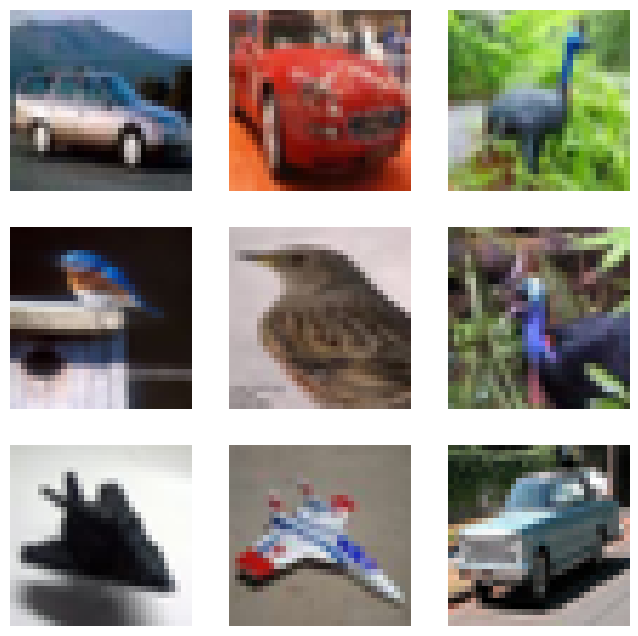

In [78]:
 # labels
num_classes=3

#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels = 32,32,3

# REDUCE THE SIZE OF TRAINING SAMPLE TO 10 000 events
x_train = x_train[0:10000]
y_train = y_train[0:10000]

# take some labels only
x_train = x_train[np.where(y_train.reshape(-1)<num_classes)]
y_train = y_train[np.where(y_train.reshape(-1)<num_classes)]
x_test = x_test[np.where(y_test.reshape(-1)<num_classes)]
y_test = y_test[np.where(y_test.reshape(-1)<num_classes)]


# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(8, 8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
plt.show()

In [79]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3011, 32, 32, 3)
3011 train samples
3000 test samples


In [80]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [81]:

print(y_train.shape)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)

(3011, 1)
(3011, 3)


In [82]:
# build and compile the model  

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=4 
ac='relu'
adm=tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.2
drop_conv=0



## **Regular convolutional network**

In [83]:

'''
model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(32, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
'''


## **Pretrained network VGG16**

https://keras.io/api/applications/

In [97]:

base_model = k.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(32, 32 , channels),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = k.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)

# Dense layers to be trained
x = k.layers.Flatten()(x)
x = k.layers.Dense(8, activation=ac,kernel_regularizer=reg)(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Dropout(drop_dense)(x)
outputs = k.layers.Dense(num_classes, activation='softmax')(x)

model = k.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)


###**Print model summary**

In [104]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 8)                 4104      
                                                                 
 batch_normalization_48 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 8)                 0         
                                                           

#**Training**

In [99]:

# training 
history=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
24/24 [==============================] - 1s 56ms/step - loss: 0.2715 - accuracy: 0.9024 - val_loss: 0.3761 - val_accuracy: 0.8570
Epoch 2/10
24/24 [==============================] - 1s 49ms/step - loss: 0.2611 - accuracy: 0.9037 - val_loss: 0.3849 - val_accuracy: 0.8547
Epoch 3/10
24/24 [==============================] - 1s 47ms/step - loss: 0.2530 - accuracy: 0.9097 - val_loss: 0.3813 - val_accuracy: 0.8510
Epoch 4/10
24/24 [==============================] - 1s 47ms/step - loss: 0.2431 - accuracy: 0.9120 - val_loss: 0.4034 - val_accuracy: 0.8490
Epoch 5/10
24/24 [==============================] - 1s 38ms/step - loss: 0.2261 - accuracy: 0.9229 - val_loss: 0.3880 - val_accuracy: 0.8567
Epoch 6/10
24/24 [==============================] - 1s 38ms/step - loss: 0.2391 - accuracy: 0.9156 - val_loss: 0.3838 - val_accuracy: 0.8600
Epoch 7/10
24/24 [==============================] - 1s 48ms/step - loss: 0.2286 - accuracy: 0.9186 - val_loss: 0.3897 - val_accuracy: 0.8600
Epoch 8/10
24

###**Calculate the model accuracy**

In [100]:
#test and training accuracy 
scores_test=model.evaluate(x_test,y_test,batch_size=128)
scores_train=model.evaluate(x_train,y_train,batch_size=128)

print("Accuracy training data: %.2f%% , test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

24/24 [==============================] - 0s 19ms/step - loss: 0.1689 - accuracy: 0.9469
Accuracy training data: 94.69% , test: 84.90% 


In [101]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

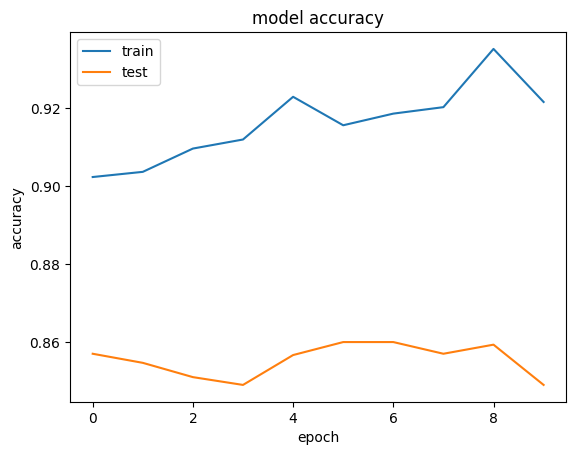

In [102]:
plothist(history)

##<font color = 'red'> **Transfer learning significantly improves our results!**

##**Plot images and their probabilities**

94/94 [==============================] - 1s 7ms/step


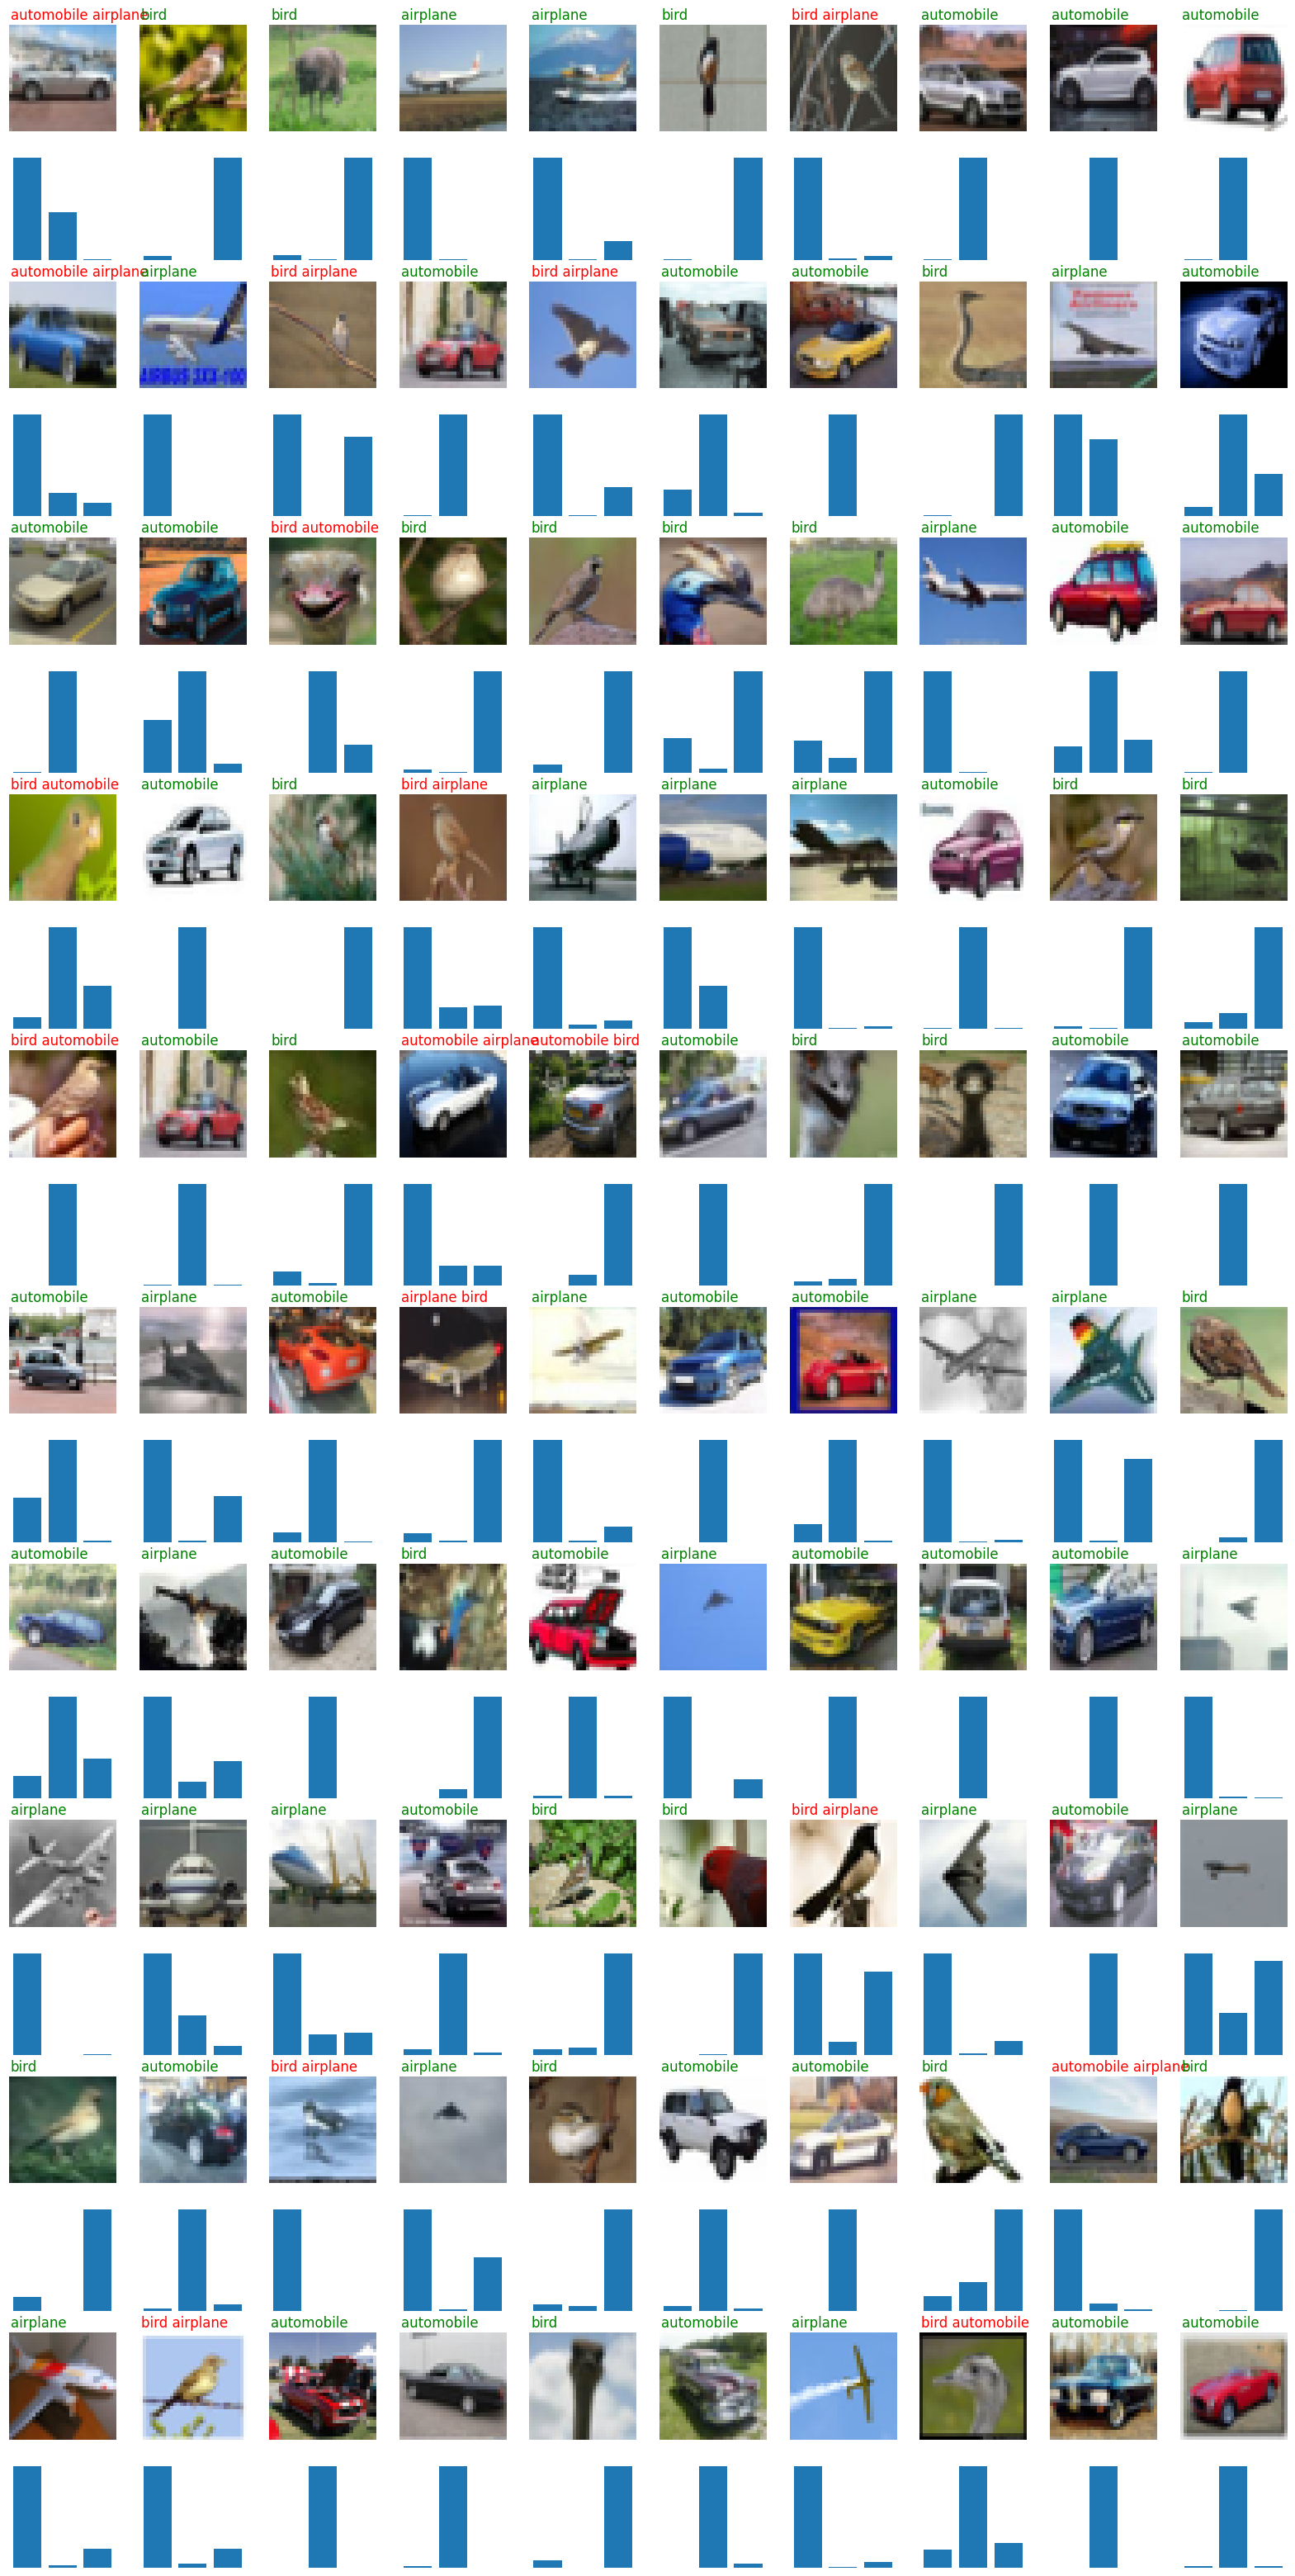

In [103]:

# Names of predicted classes (randomly chosen images)

import random


class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# this construction returns the most probable class for each event
y_pred = np.argmax(model.predict(x_test), axis = 1)
y_pred_prob = model.predict(x_test)

grid_w = 10
grid_h = 10

fig = plt.figure(figsize=(20, 40))
for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    plt.bar([0,1,2,],y_pred_prob[i_img])
    plt.axis('off')

plt.show()